In [1]:
import os
import cv2
from tqdm import tqdm
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from scipy.ndimage import maximum_filter, minimum_filter
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from skimage.filters import threshold_otsu
from skimage.metrics import peak_signal_noise_ratio as psnr

ModuleNotFoundError: No module named 'skimage'

# Setup

Get paths of the relevant files

In [488]:
input_dir = Path("data/raw/")

In [489]:
image_dir_hw = input_dir / "dibco2009/DIBC02009_Test_images-handwritten"
image_dir_pr = input_dir / "dibco2009/DIBCO2009_Test_images-printed"
output_dir = "data/processed/"
results_dir = "results"
model_dir = "models"
# make sure directories for outputs exist
os.makedirs(results_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [490]:
all_hw = sorted(glob(os.path.join(image_dir_hw, "*.tif")))
all_pr = sorted(glob(os.path.join(image_dir_pr, "*.tif")))

# Split into images and ground truth
image_paths_hw = [p for p in all_hw if "_gt" not in p]
gt_paths_hw    = [p for p in all_hw if "_gt" in p]

image_paths_pr = [p for p in all_pr if "_gt" not in p]
gt_paths_pr    = [p for p in all_pr if "_gt" in p]

Load the data

In [491]:
images_hw = {
    os.path.basename(img_path)[:-4]: (
        cv2.imread(img_path, cv2.IMREAD_GRAYSCALE),
        cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    )
    for img_path, gt_path in zip(image_paths_hw, gt_paths_hw)
}
images_pr = {
    os.path.basename(img_path)[:-4]: (
        cv2.imread(img_path, cv2.IMREAD_GRAYSCALE),
        cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    )
    for img_path, gt_path in zip(image_paths_pr, gt_paths_pr)
}
# combine the two dicts (needed for second algo)
images = { **images_hw, **images_pr}

# First Look

In [492]:
def show_input_next_to_gt(image):
    plt.subplot(1, 2, 1)
    plt.title("Input")
    plt.imshow(image[0], cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("Ground Truth")
    plt.imshow(image[1], cmap='gray')

    plt.show()

In [493]:
image_hw = images_hw[next(iter(images_hw))]
image_pr = images_pr[next(iter(images_pr))]

Handwritten image

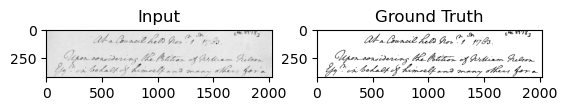

In [494]:
show_input_next_to_gt(image_hw)

Printed Image

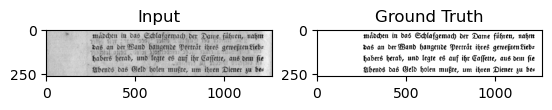

In [495]:
show_input_next_to_gt(image_pr)

# Algorithm 1 (Su et al.)

## Binarization

In [496]:
def binarize_su(image, window_size=25, N_min=6):

    # Step 1: Compute local max and min in 3×3 neighborhood
    f_max = maximum_filter(image, size=3)
    f_min = minimum_filter(image, size=3)

    # Step 2: Compute contrast (formula in the paper)
    contrast = (f_max - f_min) / (f_max + f_min + 1e-5)

    # Step 3: Threshold contrast image globally using Otsu to detect stroke boundaries
    thresh = threshold_otsu(contrast)
    hc_mask = (contrast >= thresh).astype(np.uint8)

    # Step 4: Prepare for local adaptive binarization
    pad = window_size // 2
    I_padded = np.pad(image, pad, mode='reflect')  # pad image
    H_padded = np.pad(hc_mask, pad, mode='constant')  # pad high contrast mask
    binarized = np.zeros_like(image)

    # Step 5: For each pixel, check its local neighborhood
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            roi_img = I_padded[i:i+window_size, j:j+window_size]
            roi_mask = H_padded[i:i+window_size, j:j+window_size]

            # Extract intensity values of high contrast pixels
            hc_vals = roi_img[roi_mask == 1]

            # If enough high contrast pixels are found, apply local threshold
            if len(hc_vals) >= N_min:
                mean = hc_vals.mean()
                std = hc_vals.std()
                if image[i, j] <= mean + std / 2:
                    binarized[i, j] = 255  # mark as foreground (text)

    return binarized

## Evaluation

In [497]:
results_hw = {}

# Loop over all pairs of images
for _, (name, (img, img_gt)) in enumerate(tqdm(images_hw.items())):

    # Apply Su et al. binarization
    bin_img = binarize_su(img, window_size=31, N_min=4)

    # Save binarized result next to original file
    out_name = name + "_hw_bin_su.tif"
    cv2.imwrite(os.path.join(output_dir, out_name), bin_img)

    # Prepare binary masks for evaluation
    gt_bin = (img_gt < 128).astype(np.uint8)
    pred_bin = (bin_img > 128).astype(np.uint8)

    # Calculate evaluation metrics and store them
    results_hw[name] = {
        "F1": f1_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "Precision": precision_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "Recall": recall_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "PSNR": psnr(img_gt, bin_img, data_range=255)
    }

100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


In [498]:
results_pr = {}

# Loop over all pairs of images
for _, (name, (img, img_gt)) in enumerate(tqdm(images_pr.items())):

    # Apply Su et al. binarization
    bin_img = binarize_su(img, window_size=31, N_min=4)

    # Save binarized result
    out_name = name + "_pr_bin_su.tif"
    cv2.imwrite(os.path.join(output_dir, out_name), bin_img)

    # Prepare binary masks for evaluation
    gt_bin = (img_gt < 128).astype(np.uint8)
    pred_bin = (bin_img > 128).astype(np.uint8)

    # Calculate evaluation metrics
    results_pr[name] = {
        "F1": f1_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "Precision": precision_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "Recall": recall_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "PSNR": psnr(img_gt, bin_img, data_range=255)
    }

100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Save results

In [499]:
df_hw = pd.DataFrame.from_dict(results_hw, orient="index")
df_pr = pd.DataFrame.from_dict(results_pr, orient="index")
df_hw.index.name = "Name"
df_pr.index.name = "Name"
df_hw.reset_index(inplace=True)
df_pr.reset_index(inplace=True)

In [500]:
df_hw.mean(numeric_only=True)

F1           0.189736
Precision    0.873190
Recall       0.111112
PSNR         0.234670
dtype: float64

In [501]:
df_pr.mean(numeric_only=True)

F1           0.296977
Precision    0.863217
Recall       0.187066
PSNR         0.607104
dtype: float64

In [502]:
df_all = pd.concat([df_hw, df_pr], axis=0)
df_all.mean(numeric_only=True)

F1           0.243357
Precision    0.868204
Recall       0.149089
PSNR         0.420887
dtype: float64

Save results (optional)

In [503]:
df_hw.to_csv(f"{results_dir}/results_hr_su_method.csv", index=False)
df_pr.to_csv(f"{results_dir}/results_pr_su_method.csv", index=False)
df_all.to_csv(f"{results_dir}/results_all_su_method.csv", index=False)

# Algorithm 2 (U-Net)

Get training data

In [504]:
image_dir_train = input_dir / "H-DIBCO2012-dataset"

In [505]:
images_paths_train = sorted(glob(os.path.join(image_dir_train, "*.png")))
gt_paths_train = sorted(glob(os.path.join(image_dir_train, "*.tif")))

In [506]:
images_train = {
    os.path.basename(img_path)[:-4]: (
        cv2.imread(img_path, cv2.IMREAD_GRAYSCALE),
        cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    )
    for img_path, gt_path in zip(images_paths_train, gt_paths_train)
}

In [507]:
image_train = images_train[next(iter(images_train))]

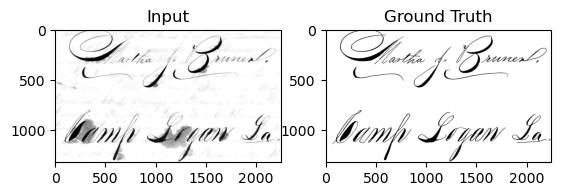

In [508]:
show_input_next_to_gt(image_train)

Convert to a format pytorch can work with

In [509]:
image_pairs_train = list(images_train.values())
image_pairs_test = list(images.values())

Create Train/Val Split

In [510]:
images_train, images_val = train_test_split(image_pairs_train, test_size=0.2, random_state=1050)

**Image Size**
U-Net expects input dimensions that are divisible by 2⁴ = 16 (due to downsampling)

In [511]:
IMG_SIZE = (256, 256)

Create custom PyTorch Dataset

In [512]:
class DocumentDataset(Dataset):
    def __init__(self, image_pairs, img_size=(256, 256), augment=False):
        self.pairs = image_pairs
        self.img_size = img_size
        self.augment = augment

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img, gt = self.pairs[idx]

        # Resize (just to make sure)
        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)
        gt = cv2.resize(gt, self.img_size, interpolation=cv2.INTER_NEAREST)

        # Normalize and binarize
        img = img.astype(np.float32) / 255.0
        gt = (gt < 128).astype(np.float32)

        # Add channel dimension
        img = np.expand_dims(img, axis=0)
        gt = np.expand_dims(gt, axis=0)

        return torch.tensor(img), torch.tensor(gt)

In [513]:
train_dataset = DocumentDataset(images_train, img_size=IMG_SIZE)
val_dataset = DocumentDataset(images_val, img_size=IMG_SIZE)

Create Dataloaders

In [514]:
train_loader = DataLoader(train_dataset, shuffle=True)
val_loader = DataLoader(val_dataset)

Model

We implement the original U-Net architecture:

- 4 downsampling + 4 upsampling stages

- 3×3 convolutions, ReLU activations

- skip connections (via concatenation)

- final 1×1 convolution to predict 1 output channel (binary mask)

 U-Net Block (Double Conv)

In [515]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Conv → ReLU → Conv → ReLU
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

U-Net Model

In [516]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        # Encoder
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up1 = DoubleConv(128, 64)

        # Output
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))

        # Bottleneck
        bn = self.bottleneck(self.pool4(d4))

        # Decoder
        u4 = self.up4(torch.cat([self.upconv4(bn), d4], dim=1))
        u3 = self.up3(torch.cat([self.upconv3(u4), d3], dim=1))
        u2 = self.up2(torch.cat([self.upconv2(u3), d2], dim=1))
        u1 = self.up1(torch.cat([self.upconv1(u2), d1], dim=1))

        return torch.sigmoid(self.out(u1))  # binary segmentation


Instantiate Model

In [517]:
unet_model = UNet(in_channels=1, out_channels=1)

## Training

Define Loss and Optimizer

In [518]:
# Binary Cross Entropy loss — compares output probabilities to ground truth masks
criterion = nn.BCELoss()

# Adam optimizer — works well for U-Net and fast convergence
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)

In [519]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()  # set model to training mode
    running_loss = 0.0

    for images, masks in dataloader:

        optimizer.zero_grad()        # reset gradients
        outputs = model(images)      # forward pass
        loss = criterion(outputs, masks)  # compute loss

        loss.backward()              # backpropagation
        optimizer.step()             # update weights

        running_loss += loss.item()  # accumulate loss

    return running_loss / len(dataloader)  # average loss over all batches

In [520]:
def evaluate(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0

    # Tracked metrics
    f1s, precisions, recalls, psnrs = [], [], [], []

    with torch.no_grad():
        for images, masks in dataloader:
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Binarize output and mask (threshold at 0.5)
            preds = (outputs > 0.5).float()

            # Convert to np for metric computation
            y_pred = preds.cpu().numpy().astype(np.uint8)
            y_true = masks.cpu().numpy().astype(np.uint8)

            for yp, yt in zip(y_pred, y_true):
                yp = (yp > 0).flatten()
                yt = (yt > 0).flatten()

                f1s.append(f1_score(yt, yp, zero_division=0))
                precisions.append(precision_score(yt, yp, zero_division=0))
                recalls.append(recall_score(yt, yp, zero_division=0))
                psnrs.append(psnr(yt.reshape(images.shape[-2:])*255, yp.reshape(images.shape[-2:])*255, data_range=255))

    # Return average loss and metrics
    return {
        "loss": val_loss / len(dataloader),
        "F1": np.mean(f1s),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "PSNR": np.mean(psnrs)
    }

Training & evaluation loop

In [521]:
num_epochs = 10              # number of training iterations
best_val_loss = float('inf')  # track best model so far

In [522]:
for epoch in range(num_epochs):
    # Train and validate for one epoch
    train_loss = train_epoch(unet_model, train_loader, optimizer, criterion)
    val_metrics = evaluate(unet_model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['loss']:.4f}")

    # Save model checkpoint if val improves
    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        torch.save(unet_model.state_dict(), f"{model_dir}/best_unet_model.pth")

Epoch 1/10 | Train Loss: 0.6902 | Val Loss: 0.6562
Epoch 2/10 | Train Loss: 0.5947 | Val Loss: 0.3630
Epoch 3/10 | Train Loss: 0.3138 | Val Loss: 0.2277
Epoch 4/10 | Train Loss: 0.2687 | Val Loss: 0.2132
Epoch 5/10 | Train Loss: 0.2614 | Val Loss: 0.2046
Epoch 6/10 | Train Loss: 0.2546 | Val Loss: 0.1975
Epoch 7/10 | Train Loss: 0.2499 | Val Loss: 0.1916
Epoch 8/10 | Train Loss: 0.2472 | Val Loss: 0.1861
Epoch 9/10 | Train Loss: 0.2422 | Val Loss: 0.1815
Epoch 10/10 | Train Loss: 0.2374 | Val Loss: 0.1747


**Results for training 10 epochs:**

- Epoch 1/10 | Train Loss: 0.6620 | Val Loss: 0.5990
- Epoch 5/10 | Train Loss: 0.2554 | Val Loss: 0.2021
- Epoch 10/10 | Train Loss: 0.2363 | Val Loss: 0.1764
- Summary:
    - Consistent improvement in both training and validation loss
    - No signs of overfitting (val loss is still decreasing)
    - Deminishing returns on Val-Loss: No need to try out more epochs

## Evaluation

Load best model

In [523]:
# Load the best saved U-Net weights
unet_model.load_state_dict(torch.load(f"{model_dir}/best_unet_model.pth"))
unet_model.eval();  # set to evaluation mode

Run evaluation

In [524]:
results_unet = {}

for name, (img, gt) in images.items():
    # Resize to match training input size
    img_resized = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    gt_resized = cv2.resize(gt, (256, 256), interpolation=cv2.INTER_NEAREST)

    # Convert to tensor
    input_tensor = torch.tensor(img_resized / 255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Predict
    with torch.no_grad():
        output = unet_model(input_tensor)
        bin_pred = (output.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255

    # Resize prediction back to original size
    bin_pred_orig = cv2.resize(bin_pred, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Binarize for evaluation
    gt_bin = (gt < 128).astype(np.uint8)
    pred_bin = (bin_pred_orig > 128).astype(np.uint8)

    # Compute metrics
    results_unet[name] = {
        "F1": f1_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "Precision": precision_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "Recall": recall_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "PSNR": psnr(gt, bin_pred_orig, data_range=255)
    }

In [525]:
results_unet_df = pd.DataFrame.from_dict(results_unet, orient="index")
results_unet_df.index.name = "Name"
results_unet_df.reset_index(inplace=True)

In [526]:
results_unet_df.mean(numeric_only=True)

F1           0.000000
Precision    0.000000
Recall       0.000000
PSNR         0.488751
dtype: float64

Save results (optional)

In [528]:
results_unet_df.to_csv(f"{results_dir}/results_unet_method.csv", index=False)